In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import roc_auc_score


from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard,CSVLogger
from keras.models import load_model

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"



Using TensorFlow backend.


In [2]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [6]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8')
df.head()

,x,n,u,Events
0,-12.28,-92.30,-9.23,0.0
1,-12.58,-92.54,-11.31,0.0
2,-13.16,-92.24,-8.02,0.0
3,-13.21,-92.20,-11.51,0.0
4,-12.92,-93.19,-10.20,0.0


In [7]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(229716, 3) (229716,)


In [8]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [14]:
# Temporalize the data
lookback = 40
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



In [15]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [16]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
# X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
# X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
# X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
# X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)b
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [17]:
y_train.shape

(146992,)

In [18]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [19]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

40 3 1


In [20]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

### Stardarization

In [21]:
# Initialize a scaler using the training data.
# scaler = StandardScaler().fit(flatten(X_train))

In [22]:
# Standarize the input

# X_train_scaled = scale(X_train, scaler)
# X_valid_scaled = scale(X_valid, scaler)
# X_test_scaled = scale(X_test, scaler)

### Test Standarization

In [23]:
# a = flatten(X_train_scaled)
# print('colwise mean', np.mean(a,axis=0).round(6))
# print('colwise variance', np.var(a, axis=0))



# Test acurracy

Not use for now

In [ ]:
# fit and evaluate a model
# def evaluate_model(X_train, y_train, X_test, y_test):
    
#     verbose, epochs, batch_size = 1, 15, 64
#     n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
#     model = Sequential()
#     model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
#     model.add(Dropout(0.5))
#     model.add(Dense(100, activation='relu'))
# #     model.add(Dense(n_outputs, activation='softmax'))
#     model.add(Dense(n_outputs, activation='sigmoid'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     # fit network
#     model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_valid, y_valid),verbose=verbose)
#     # evaluate model
#     _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    
#     return accuracy

In [ ]:
# summarize scores
# def summarize_results(scores):
#     print(scores)
#     m, s = np.mean(scores), np.std(scores)
#     print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [ ]:
# run an experiment
# def run_experiment(repeats=2):
#     # repeat experiment
#     scores = list()
#     for r in range(repeats):
#         score = evaluate_model(X_train, y_train, X_test, y_test)
#         score = score * 100.0
#         print('>#%d: %.3f' % (r+1, score))
#         scores.append(score)
#     # summarize results
#     summarize_results(scores)
 
    # run the experiment
# run_experiment()

# Model training

Training models (Use it)


In [24]:
# Parameters

verbose, epochs, batch_size = 1, 150, 64



model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cp = ModelCheckpoint(filepath="/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40window_final.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/home/francovm/Projects/SSE/models/Binary_clasifier/Tensorboard/Binary_clasifier_LSTM_SSE_40window_final',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

csv_logger = CSVLogger('/home/francovm/Projects/SSE/data/Visualization/Data/Binary_clasifier_LSTM_SSE_40window_final.csv', append=True, separator=';')

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=7)

# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_valid, y_valid), verbose=verbose,
                    callbacks=[early_stopping_monitor,csv_logger,tb,cp])


# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 146992 samples, validate on 36748 samples


Epoch 1/150
 16512/146992 [==>...........................] - ETA: 3:17 - loss: 0.2336 - accuracy: 0.9316

KeyboardInterrupt: 

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-40days-acc-shifted.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-40days-loss-shifted_.png')
plt.show()

In [ ]:
# save model and architecture to single file
# model.save("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days-shifted.h5")


In [26]:
# load model
model = load_model('/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days.h5')
# summarize model.
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [27]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

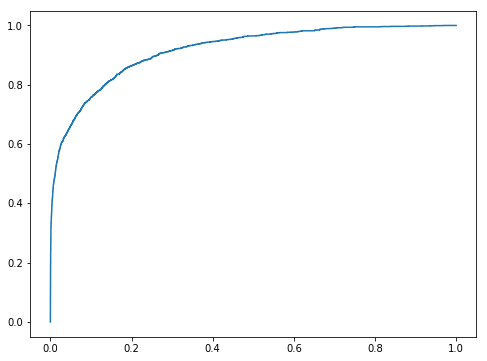

In [28]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs)

plt.plot(fpr,tpr)
plt.show()

In [29]:
# calculate AUC
auc = roc_auc_score(y_test, yhat_probs)
print('AUC: %.3f' % auc)

AUC: 0.918


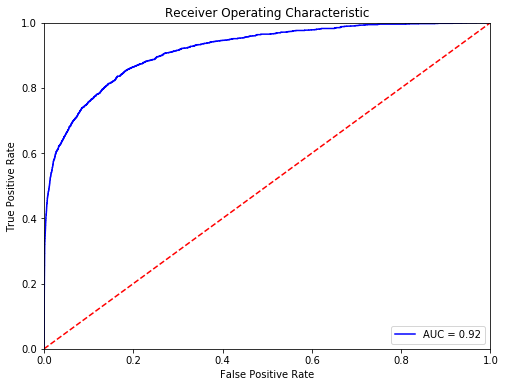

In [30]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1.]
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Figure size 720x720 with 0 Axes>

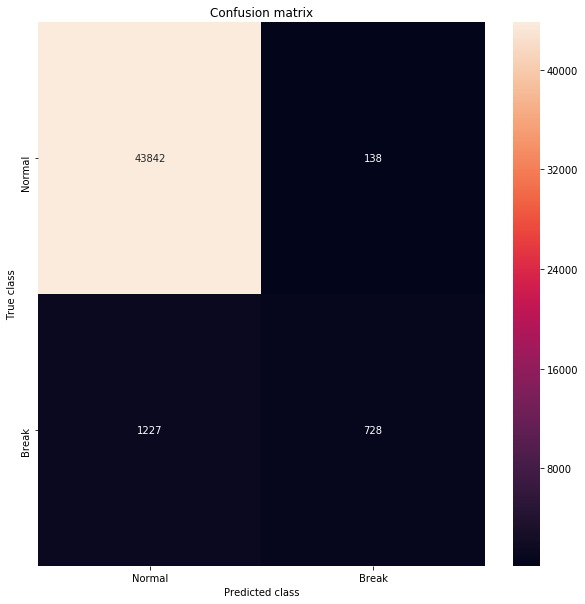

In [31]:
conf_matrix = confusion_matrix(y_test, yhat_classes)
# conf_matrix = confusion_matrix( y_pred_40,y_pari.astype(int))


plt.figure(figsize=(10, 10))
# Normalise
cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

# ax = sns.heatmap(cmn, xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()